In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 0
despine_trim = True

### Load the data for the total and downsampled T-width values for the hTERT cell lines.

In [3]:
# load table of T-width values
df = pd.read_csv('../../analysis/sig_lines/twidth_values.tsv', sep='\t')
df.head()

,dataset,infer_mode,per_cell,T-width,num_cells,num_clones,cell_type
0,SA039,pyro,False,2.024823,1437,5,WT
1,SA039,pyro,True,2.038687,1437,5,WT
2,SA906a,pyro,False,2.050962,1421,14,TP53-/-
3,SA906a,pyro,True,2.084920,1421,14,TP53-/-
4,SA906b,pyro,False,2.181793,1146,13,TP53-/-


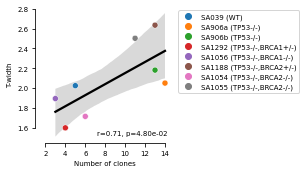

In [4]:
def plot_twidth_vs_num_clones(df, ax):
    plot_data = df.query("per_cell==False")
    # plot a regplot of T-width vs num_clones
    sns.regplot(data=plot_data, x='num_clones', y='T-width', fit_reg=True, scatter=False, ax=ax, color='k')
    sns.scatterplot(data=plot_data, x='num_clones', y='T-width', hue='dataset', ax=ax)

    # compute the pearson correlation coefficient (r and p-value) and add to plot
    r, p = stats.pearsonr(plot_data['num_clones'], plot_data['T-width'])
    ax.text(0.95, 0.05, f'r={r:.2f}, p={p:.2e}', transform=ax.transAxes, ha='right', va='bottom')

    # set the x-axis limits to be from 0 to the maximum number of clones + 1
    ax.set_xlim(1, plot_data['num_clones'].max()+1)
    # set the x ticks to be even numbers from 2 to 14
    ax.set_xticks(np.arange(2, 15, 2))

    ax.set_xlabel('Number of clones')
    ax.set_ylabel('T-width')

    # for each label, add a suffix with the corresponding cell_type according to the dataset to cell_type mapping in plot_data
    handles, labels = ax.get_legend_handles_labels()
    labels = [f'{label} ({plot_data.query("dataset==@label")["cell_type"].iloc[0]})' for label in labels]
    # move the legend to the right of the plot
    ax.legend(handles=handles, labels=labels, ncol=1, loc='upper left', bbox_to_anchor=(1, 1))

    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

    return ax

fig, ax = plt.subplots(figsize=(2.5, 2.5))
plot_twidth_vs_num_clones(df, ax)
plt.show()

In [5]:
# load the table of downsampled T-width values
df2 = pd.read_csv('../../analysis/sig_lines/downsampled_twidth_values.tsv', sep='\t')
df2.head()

,dataset,num_cells,per_cell,T-width,cell_type
0,OV2295,273,False,2.258036,NaN
1,OV2295,273,True,2.147231,NaN
2,SA039,25,False,1.914747,"hTERT,WT"
3,SA039,25,True,1.947483,"hTERT,WT"
4,SA039,25,False,2.125560,"hTERT,WT"


In [6]:
# compute the deviation from the true T-width value for each subsample
true_tws = df2.query("num_cells>375")
true_tws['True-Tw'] = true_tws['T-width']
true_tws = true_tws[['dataset', 'per_cell', 'True-Tw']]
df2 = pd.merge(df2, true_tws)
df2['Tw-diff'] = df2['T-width'] - df2['True-Tw']
df2.head()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,dataset,num_cells,per_cell,T-width,cell_type,True-Tw,Tw-diff
0,SA039,25,False,1.914747,"hTERT,WT",2.024823,-0.110075
1,SA039,25,False,2.125560,"hTERT,WT",2.024823,0.100737
2,SA039,25,False,1.857559,"hTERT,WT",2.024823,-0.167264
3,SA039,25,False,2.117134,"hTERT,WT",2.024823,0.092311
4,SA039,25,False,2.126280,"hTERT,WT",2.024823,0.101458


In [7]:
df2.dtypes

dataset       object
num_cells      int64
per_cell        bool
T-width      float64
cell_type     object
True-Tw      float64
Tw-diff      float64
dtype: object

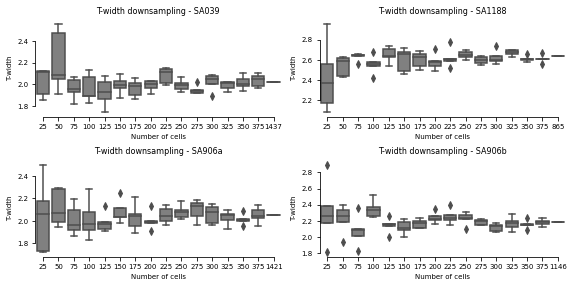

In [8]:
def plot_twidth_downsamples(df, ax0, ax1, ax2, ax3):
    datasets = ['SA039', 'SA1188', 'SA906a', 'SA906b']
    for ax, d in zip([ax0, ax1, ax2, ax3], datasets):
        plot_data = df.query("dataset==@d").query("per_cell==False")
        sns.boxplot(data=plot_data, x='num_cells', y='T-width', ax=ax, color='grey', )
        ax.set_title('T-width downsampling - {}'.format(d))
        ax.set_xlabel('Number of cells')
        ax.set_ylabel('T-width')

        sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

    return ax0, ax1, ax2, ax3

fig, ax = plt.subplots(2, 2, figsize=(8, 4), tight_layout=True)
ax0, ax1, ax2, ax3 = ax.flatten()
plot_twidth_downsamples(df2, ax0, ax1, ax2, ax3)
plt.show()

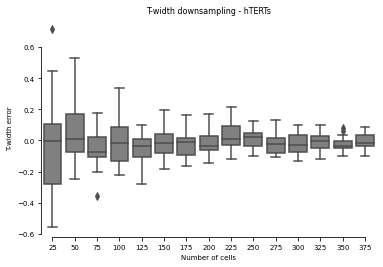

In [9]:



def plot_downsample_error_summary(df, ax):
    plot_data = df.query("per_cell==False").query('num_cells<=375')

    sns.boxplot(data=plot_data, y='Tw-diff', x='num_cells', ax=ax, color='grey')
    ax.set_xlabel('Number of cells')
    ax.set_ylabel('T-width error')
    ax.set_title('T-width downsampling - hTERTs')

    sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)

    return ax

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_downsample_error_summary(df2, ax)
plt.show()

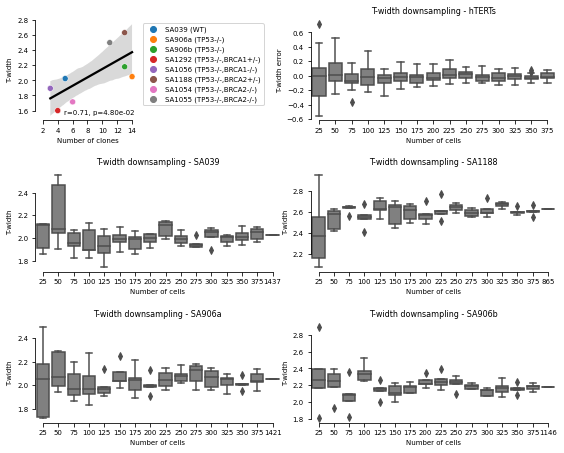

In [10]:
fig = plt.figure(figsize=(8.5, 7))

# create a small subplot in the top left corner of the figure
ax0 = fig.add_axes([0.1, 0.7, 0.17, 0.2])

# create a larger subplot in the top right corner of the figure
# have the same height as the top left subplot, but twice the width
ax1 = fig.add_axes([0.55, 0.7, 0.4, 0.2])

# create a 2x2 grid of subplots in the bottom half of the figure which are the same size as the top right subplot
ax2 = fig.add_axes([0.1, 0.4, 0.4, 0.2])
ax3 = fig.add_axes([0.55, 0.4, 0.4, 0.2])
ax4 = fig.add_axes([0.1, 0.1, 0.4, 0.2])
ax5 = fig.add_axes([0.55, 0.1, 0.4, 0.2])

# plot the relationship between T-width value and the number of clones in the top left subplot
plot_twidth_vs_num_clones(df, ax0)

# plot the downsample error summary in the top right subplot
plot_downsample_error_summary(df2, ax1)

# plot the downsampled T-width values for each dataset in the bottom two rows
plot_twidth_downsamples(df2, ax2, ax3, ax4, ax5)

# save the figure
fig.savefig('../../manuscript/supplementary_figs/figS4.pdf', dpi=300, bbox_inches='tight')

plt.show()